In [1]:
from principal_DBN_alpha import *
from principal_RBM_alpha import *
from utils import *
from tqdm import tqdm, notebook
import matplotlib.pyplot as plt

# Etude sur Binary AlphaDigit

In [2]:
data = lire_alpha_digit(caracs, path_data=path_data)

## RBM 

On entraine un RBM sur les données de Binary AlphaDigit puis on genere des images à partir de ce qu'il a appris.

In [3]:
neurons = 200
epochs = 200
nb_pixels = 20*16
learning_rate = 0.1
gibbs_steps = 200

In [4]:
data.shape

(1404, 320)

On entraine un RBM pour chaque caractère.

In [4]:
list_rbm_caracs = []
for carac in notebook.tqdm(list(caracs.keys()), desc="Characters", unit="char", leave=False):
    data = lire_alpha_digit([carac], path_data)
    nb_pixels = data.shape[1]
    rbm = RBM(p = nb_pixels, q = neurons)
    rbm.train_RBM(x=data, epochs=epochs, lr=learning_rate, show_progress=True)
    list_rbm_caracs.append(rbm)

Characters:   0%|          | 0/36 [00:00<?, ?char/s]

Training RBM: 100%|██████████| 200/200 [00:01<00:00, 118.07epoch/s, reconstruction_error=0.25]


On genere des images des caractères en utilisant la méthode de Gibbs Sampling.

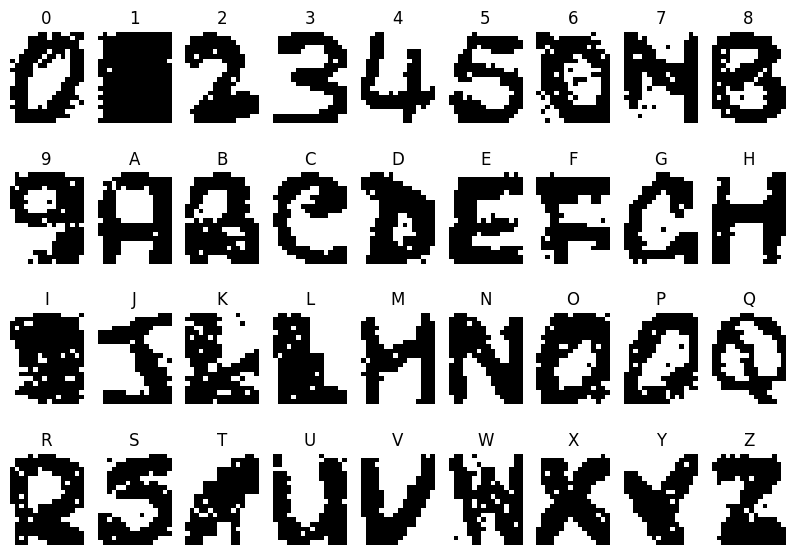

In [5]:
fig, axs = plt.subplots(4, 9, figsize=(10, 7), sharex=True, sharey=True)
axs = axs.flatten()

for i, rbm in enumerate(list_rbm_caracs):
    img = rbm.generer_image_RBM(gibbs_steps, 1)  # 1 image with 100 Gibbs steps
    
    img_reshaped = img[0].cpu().reshape(20, 16)
    
    axs[i].imshow(img_reshaped, cmap='Greys')
    axs[i].set_title(list(caracs.keys())[i])
    axs[i].axis('off')

# Adjust layout to prevent overlap
# plt.tight_layout()
plt.show()


## DBN

In [7]:
liste_dbn_caracs = []
for carac in notebook.tqdm(list(caracs.keys()), desc="Characters", unit="char", leave=True):
            data = lire_alpha_digit([carac], path_data)     
            nb_pixels = data.shape[1]
            # les couches du dbn (de chaque rbm en soit)
            layers = [nb_pixels, neurons, neurons, neurons]

            dbn = DBN(layers=layers)
            dbn.train_DBN(x=data, epochs=[epochs], lr=learning_rate, plot=False, show_progress=True)
            liste_dbn_caracs.append(dbn)

Characters:   0%|          | 0/36 [00:00<?, ?char/s]

Training DBN: 100%|██████████| 3/3 [00:01<00:00,  1.52RBM/s]


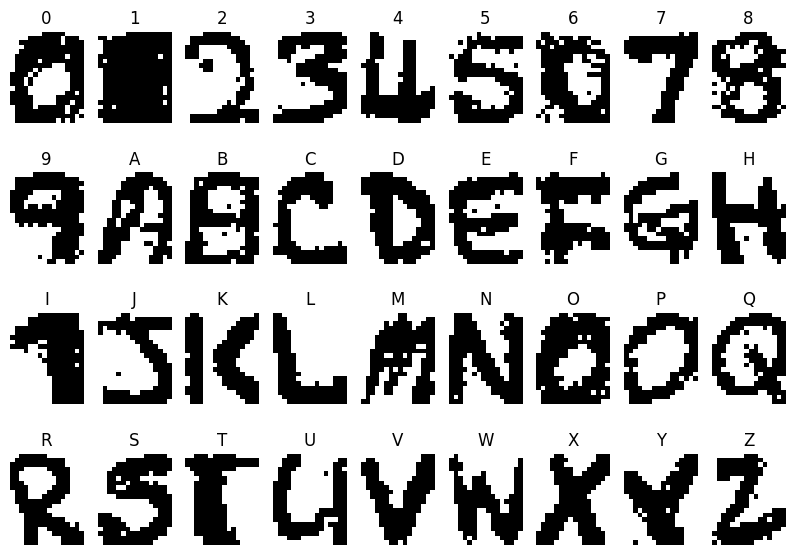

In [8]:
fig, axs = plt.subplots(4, 9, figsize=(10, 7), sharex=True, sharey=True)
axs = axs.flatten()

for i, dbn in enumerate(liste_dbn_caracs):
    img = dbn.generer_image_DBN(gibbs_steps, 1)  # 1 image with 100 Gibbs steps
    
    img_reshaped = img[0].cpu().reshape(20, 16)
    
    axs[i].imshow(img_reshaped, cmap='Greys')
    axs[i].set_title(list(caracs.keys())[i])
    axs[i].axis('off')

# Adjust layout to prevent overlap
# plt.tight_layout()
plt.show()

# Étude sur MNIST

## Chargement des données MNIST et processing

In [9]:
from principal_DNN_MNIST import *

In [16]:
import torchvision.datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, transform=None, download=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, transform=None, download=True)
batch_size = 100

train_set.data = (train_set.data > 127).float()
test_set.data = (test_set.data > 127).float()


# Applatir les images (28*28) en vecteurs (784)
train_mnist = train_set.data.view(train_set.data.shape[0], -1).double().to(device)
test_mnist = test_set.data.view(test_set.data.shape[0], -1).double().to(device) 


In [17]:
# One Hot Encoding des labels
labels_train_mnist = torch.nn.functional.one_hot(train_set.targets).float().to(device)
labels_test_mnist = torch.nn.functional.one_hot(test_set.targets).float().to(device)


train_mnist.shape, labels_train_mnist.shape, test_mnist.shape, labels_test_mnist.shape


(torch.Size([60000, 784]),
 torch.Size([60000, 10]),
 torch.Size([10000, 784]),
 torch.Size([10000, 10]))

## Test du DNN sur MNIST

In [19]:
nb_pixels = train_mnist.shape[1]
neurons = 200
epochs = 200
learning_rate = 0.1
layers_dbn = [nb_pixels, neurons, neurons, neurons]
nb_classes = len(train_set.class_to_idx)

### DNN pré-entrainé

In [ ]:
dnn_pretrain = DNN(layers_dbn, nb_classes=nb_classes)
dnn_pretrain.pretrain_DNN(x=train_mnist, epochs=[epochs], lr=learning_rate)

In [18]:
train_mnist.dtype

torch.float64